# Basic GAN

# Anime Generation using Basic GAN model

The basic GAN model described in the introduction of the previous notebook takes in noise vectors as inputs through the Generator and continually produce fake samples of anime which would be evaluated by the Discriminator. In this notebook we will run a basic GAN model using Ghibli Anime images as standard bearer of anime images for the discriminator to see what type of images are generated by the Generator after training.

## GAN Architecture

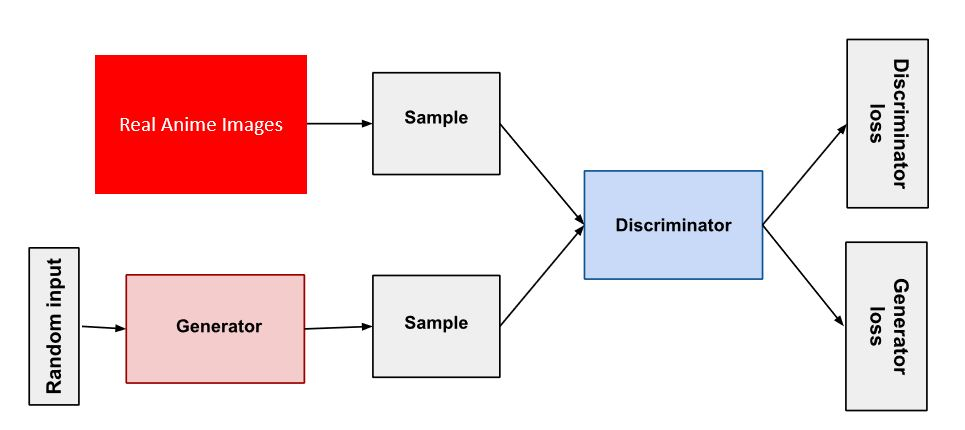

Code is adapted from this [website](https://www.analyticsvidhya.com/blog/2021/04/generate-your-own-dataset-using-gan/):

**Note**: This notebook was originally run on Google Colab and was reading files from Google Drive, but has been amended to reconcile with the local drive data structure required for github upload. Run cells has been copied from Google Colab such as training cell and pasted into this notebook as proof that the model was trained and showing all the expected output and generated images. This notebook may show Notebook Validation Error when opened locally.

In [1]:
# import the libraries
import tensorflow as tf
from tensorflow.keras.layers import Input, Reshape, Dropout, Dense 
from tensorflow.keras.layers import Flatten, BatchNormalization
from tensorflow.keras.layers import Activation, ZeroPadding2D
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import UpSampling2D, Conv2D, Conv2DTranspose
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.optimizers import Adam
import tensorflow_datasets as tfds
import numpy as np
import os 
import time
import matplotlib.pyplot as plt
import pathlib

In [4]:
# function to display elapsed time
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return "{}:{:>02}:{:>05.2f}".format(h, m, s)

In [5]:
# define the latent vector, training images and configuration
generate_res = 4 # Generation resolution factor 
# (1=32, 2=64, 3=96, 4=128, etc.)
generate_square = 32 * generate_res # rows/cols (should be square)
image_channels = 3

# Preview image 
preview_rows = 4
preview_cols = 7
preview_margin = 16

# Size vector to generate images from
seed_size = 100

# Configuration
data_path = '../model_and_gen_img/Basic_GAN_Anime_Generator/'
epochs = 200
batch_size = 32
buffer_size = 60000

print(f"Will generate {generate_square}px square images.")

Will generate 128px square images.


In [6]:
data_dir = '../data/anime_ghibli_6079'

anime_dir = pathlib.Path(data_dir)

batch_size = 32
img_height = generate_square
img_width = generate_square

train_ds = tf.keras.utils.image_dataset_from_directory(
  anime_dir,
  labels=None,
  label_mode=None,
  seed=42,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6079 files belonging to 1 classes.


## Sample Images

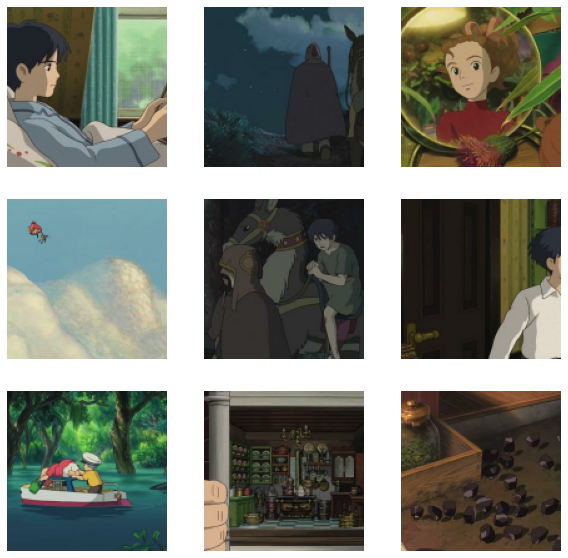

In [7]:
# show some anime samples

plt.figure(figsize=(10, 10))
for images in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.axis("off")

In [8]:
# check the batch size
for image_batch in train_ds:
  print(image_batch.shape)
  break

(32, 128, 128, 3)


In [ ]:
# normalize the images to between -1 and 1
normalization_layer = tf.keras.layers.Rescaling(1./127.5, offset=-1)
train_dataset = train_ds.map(lambda x: (normalization_layer(x)))

## Generator

In [10]:
# create the generator
def build_generator(seed_size, channels):
    model = Sequential()

    model.add(Dense(4*4*256,activation="relu",input_dim=seed_size))
    model.add(Reshape((4,4,256)))

    model.add(UpSampling2D())
    model.add(Conv2D(256,kernel_size=3,padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Activation("relu"))

    model.add(UpSampling2D())
    model.add(Conv2D(256,kernel_size=3,padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Activation("relu"))
   
    # Output resolution, additional upsampling
    model.add(UpSampling2D())
    model.add(Conv2D(128,kernel_size=3,padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Activation("relu"))

    if generate_res>1:
      model.add(UpSampling2D(size=(generate_res,generate_res)))
      model.add(Conv2D(128,kernel_size=3,padding="same"))
      model.add(BatchNormalization(momentum=0.8))
      model.add(Activation("relu"))

    # Final CNN layer
    model.add(Conv2D(channels,kernel_size=3,padding="same"))
    model.add(Activation("tanh"))

    return model

## Discriminator

In [11]:
# create the discriminator
def build_discriminator(image_shape):
    model = Sequential()

    model.add(Conv2D(32, kernel_size=3, strides=2, input_shape=image_shape, 
                     padding="same"))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Dropout(0.25))
    model.add(Conv2D(64, kernel_size=3, strides=2, padding="same"))
    model.add(ZeroPadding2D(padding=((0,1),(0,1))))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Dropout(0.25))
    model.add(Conv2D(128, kernel_size=3, strides=2, padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Dropout(0.25))
    model.add(Conv2D(256, kernel_size=3, strides=1, padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Dropout(0.25))
    model.add(Conv2D(512, kernel_size=3, strides=1, padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))

    return model

In [12]:
# save images created by generator
def save_images(cnt,noise):
  image_array = np.full(( 
      preview_margin + (preview_rows * (generate_square+preview_margin)), 
      preview_margin + (preview_cols * (generate_square+preview_margin)), 3), 
      255, dtype=np.uint8)
  
  generated_images = generator.predict(noise)

  generated_images = 0.5 * generated_images + 0.5

  image_count = 0
  for row in range(preview_rows):
      for col in range(preview_cols):
        r = row * (generate_square+16) + preview_margin
        c = col * (generate_square+16) + preview_margin
        image_array[r:r+generate_square,c:c+generate_square] = generated_images[image_count] * 255
        image_count += 1

          
  output_path = os.path.join(data_path,'output')
  if not os.path.exists(output_path):
    os.makedirs(output_path)
  
  filename = os.path.join(output_path,f"train-{cnt}.png")
  im = Image.fromarray(image_array)
  im.save(filename)

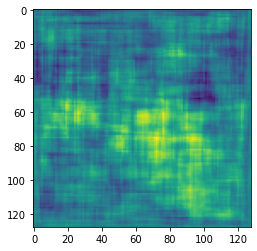

In [13]:
# build the untrained generator and display the generated image using noise
generator = build_generator(seed_size, image_channels)

noise = tf.random.normal([1, seed_size])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0])

In [14]:
# shows the output from the discriminator
image_shape = (generate_square,generate_square,image_channels)

discriminator = build_discriminator(image_shape)
decision = discriminator(generated_image)
print (decision)

tf.Tensor([[0.50002736]], shape=(1, 1), dtype=float32)


## Loss Function

In [15]:
# define the loss functions
cross_entropy = tf.keras.losses.BinaryCrossentropy()

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [16]:
# use adam optimizer
generator_optimizer = tf.keras.optimizers.Adam(1.5e-4,0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(1.5e-4,0.5)

In [17]:
# training of the model
@tf.function
def train_step(images):
  seed = tf.random.normal([batch_size, seed_size])

  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    generated_images = generator(seed, training=True)

    real_output = discriminator(images, training=True)
    fake_output = discriminator(generated_images, training=True)

    gen_loss = generator_loss(fake_output)
    disc_loss = discriminator_loss(real_output, fake_output)
    

    gradients_of_generator = gen_tape.gradient(
        gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(
        disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(
        gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(
        gradients_of_discriminator, 
        discriminator.trainable_variables))
  return gen_loss,disc_loss

In [18]:
#define the checkpoint save directory path
checkpoint_dir = data_path +'training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [19]:
# define the training function
def train(dataset, epochs):
  fixed_seed = np.random.normal(0, 1, (preview_rows * preview_cols, 
                                       seed_size))
  start = time.time()

  for epoch in range(epochs):
    epoch_start = time.time()

    gen_loss_list = []
    disc_loss_list = []

    for image_batch in dataset:
      t = train_step(image_batch)
      gen_loss_list.append(t[0])
      disc_loss_list.append(t[1])

    g_loss = sum(gen_loss_list) / len(gen_loss_list)
    d_loss = sum(disc_loss_list) / len(disc_loss_list)

    epoch_elapsed = time.time()-epoch_start
    print (f'Epoch {epoch+1}, gen loss={g_loss},disc loss={d_loss}, {hms_string(epoch_elapsed)}')
    save_images(epoch,fixed_seed)

    # Save the model every 15 epochs
    if (epoch + 1) % 15 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

  elapsed = time.time()-start
  print (f'Training time: {hms_string(elapsed)}')

In [ ]:
# train the GAN for 200 epochs
train(train_dataset, epochs)

Epoch 1, gen loss=4.057419776916504,disc loss=1.5518337488174438, 0:00:22.61
Epoch 2, gen loss=3.2212345600128174,disc loss=1.4158821105957031, 0:00:18.60
Epoch 3, gen loss=2.1006550788879395,disc loss=1.3610807657241821, 0:00:18.58
Epoch 4, gen loss=1.3482879400253296,disc loss=1.6570638418197632, 0:00:18.61
Epoch 5, gen loss=1.4484424591064453,disc loss=1.5510053634643555, 0:00:18.58
Epoch 6, gen loss=1.4572491645812988,disc loss=1.560340166091919, 0:00:18.58
Epoch 7, gen loss=1.4804885387420654,disc loss=1.550626516342163, 0:00:18.59
Epoch 8, gen loss=1.5175361633300781,disc loss=1.5344525575637817, 0:00:18.57
Epoch 9, gen loss=1.4294166564941406,disc loss=1.5009894371032715, 0:00:18.58
Epoch 10, gen loss=1.5412355661392212,disc loss=1.4719257354736328, 0:00:20.48
Epoch 11, gen loss=1.4131896495819092,disc loss=1.419737458229065, 0:00:18.59
Epoch 12, gen loss=1.567976474761963,disc loss=1.473518967628479, 0:00:18.57
Epoch 13, gen loss=1.5341150760650635,disc loss=1.328723430633545, 

## Key Observations

Generator outputs from the training set:

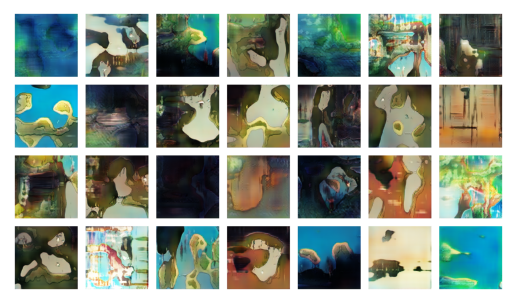

In [4]:
#https://stackoverflow.com/questions/20597088/display-a-png-image-from-python-on-mint-15-linux
import matplotlib.image as mpimg

plt.figure(figsize= (9,6))
img = mpimg.imread("../model_and_gen_img/Basic_GAN_Anime_Generator/output/train-199.png")
plt.imshow(img)
plt.axis('off')
plt.show()

After 200 epochs, the generator produces images that clearly has the style of Ghibli Anime, but with no recognizable features such as human or scenery. This is expected since the Ghibli Anime images used in this GAN is a mixture of themes. A consistent theme in the anime images may improve the generated image theme, but this is beyond the scope of this project. Nevertheless, this may hold some lesson for the real-life to anime image translation problem which is the focus of the project.

# Experimenting with Real-Life Image Cartoonization with Basic GAN

The generated anime images from the Basic GAN model are very fascinating - the Ghibli Anime style could be clearly seen, but the content of the images is unclear, as you cannot distinguish whether the generated image is a human character or a scenery. 

This begs the question of whether a basic GAN can transfer the style of anime onto a real-life image while keeping the content intact. We will attempt to find out by replacing the noise vectors (random input) with real-life image as inputs into the Generator.

In [21]:
#import the libraries
import tensorflow as tf
from keras.initializers import RandomNormal
from tensorflow.keras.layers import Input, Reshape, Dropout, Dense 
from tensorflow.keras.layers import Flatten, BatchNormalization
from tensorflow.keras.layers import Activation, ZeroPadding2D
from tensorflow.keras.layers import LeakyReLU, ReLU
from tensorflow.keras.layers import UpSampling2D, Conv2D, Conv2DTranspose
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Concatenate, Rescaling
from tensorflow.keras.optimizers import Adam
from PIL import Image
import numpy as np
import os 
import time
import matplotlib.pyplot as plt
import pathlib
!pip install visualkeras
import visualkeras

     |████████████████████████████████| 795 kB 4.7 MB/s 


## GAN Architecture

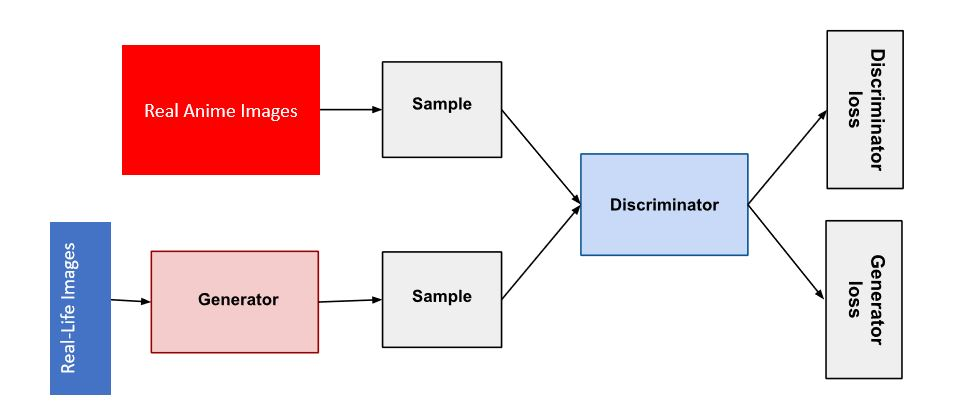

We will first define the size of images, the batch size and the layout of the preview images. We chose 128x128 pixels as the image size as a compromise between image quality and computational time

In [23]:
# define the training images and configuration
generate_res = 4 # Generation resolution factor 
# (1=32, 2=64, 3=96, 4=128, etc.)
generate_square = 32 * generate_res # rows/cols (should be square)
image_channels = 3

# preview image 
preview_rows = 4
preview_cols = 7
preview_margin = 16

# configuration
data_path = '../model_and_gen_img/Basic_GAN_Real_Input/'
epochs = 200
batch_size = 32

real_image_shape = (generate_square, generate_square, image_channels)

print(f"Will generate {generate_square}px square images.")

Will generate 128px square images.


In [24]:
# define helper function to display elapsed time
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return "{}:{:>02}:{:>05.2f}".format(h, m, s)

## Sample Images

We set up a `tf.data.Dataset` from both the Anime and Real-Life images directory and show some samples images from each domain

In [25]:
data_dir = '../data/anime_ghibli_6079'

anime_dir = pathlib.Path(data_dir)

train_ds = tf.keras.utils.image_dataset_from_directory(
  anime_dir,
  labels=None,
  label_mode=None,
  seed=132,
  image_size=(real_image_shape[0], real_image_shape[1]),
  batch_size=batch_size)

Found 6079 files belonging to 1 classes.


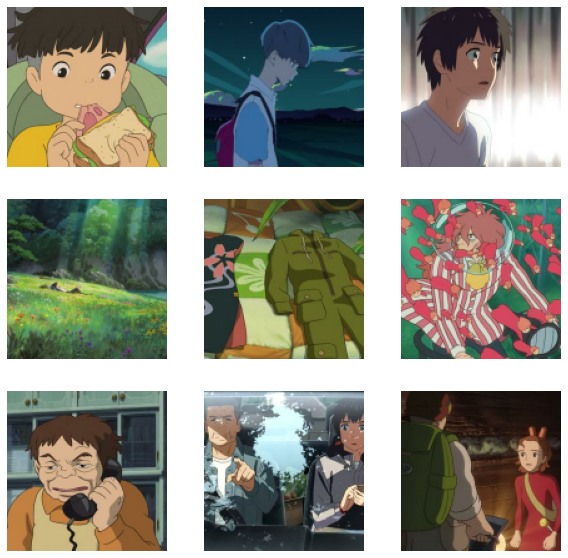

In [26]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.axis("off")

In [27]:
#check on the dimension of each batch
for image_batch in train_ds:
  print(image_batch.shape)
  break

(32, 128, 128, 3)


In [28]:
data_dir = '../data/real_unsplash_6387'

real_dir = pathlib.Path(data_dir)

batch_size = 32
img_height = generate_square
img_width = generate_square

input_ds = tf.keras.utils.image_dataset_from_directory(
  real_dir,
  labels=None,
  label_mode=None,
  seed=132,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6387 files belonging to 1 classes.


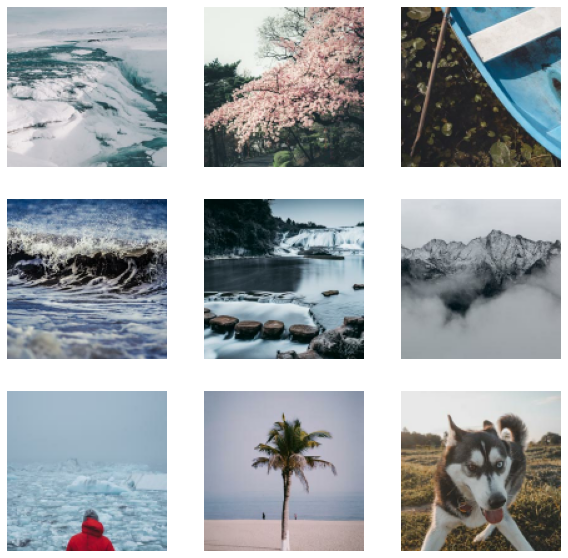

In [29]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images in input_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.axis("off")

In [30]:
# check on the dimension of each batch
for image_batch in input_ds:
  print(image_batch.shape)
  break

(32, 128, 128, 3)


As the generator uses the `tanh` activation function, all the images are scaled to the range of [-1,1] as inputs to both the generator and discriminator

In [31]:
normalization_layer = Rescaling(1./127.5, offset=-1)
train_dataset = train_ds.map(lambda x: (normalization_layer(x)))
input_dataset = input_ds.map(lambda x: (normalization_layer(x)))

## Generator

As this GAN model requires an input real-life image, we have to modify the generator model in the Basic GAN to a U-Net model. The U-Net model architecture involves downsampling an image over a few layers to a bottleneck layer and then upsampling over a few layers to an output image of the desired size. Skip connections are added between the first and last layers, the second and second last and so on so that the low-level information in the input are shared with the output with the desired effect of the output image retaining the content of the input image ([*source*](https://machinelearningmastery.com/how-to-develop-a-pix2pix-gan-for-image-to-image-translation/)).

Codes for the U-Net generator are adapted from the Tensorflow tutorial webpage ([*source*](https://www.tensorflow.org/tutorials/generative/pix2pix))

In [32]:
# downsampling function for the u-net generator
def downsample(filters, size, apply_batchnorm=True):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = Sequential()
  result.add(
      Conv2D(filters, size, strides=2, padding='same',
             kernel_initializer=initializer, use_bias=False))

  if apply_batchnorm:
    result.add(BatchNormalization())

  result.add(LeakyReLU())

  return result

In [33]:
# upsampling function for the u-net generator
def upsample(filters, size, apply_dropout=False):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = Sequential()
  result.add(
    Conv2DTranspose(filters, size, strides=2,
                    padding='same',
                    kernel_initializer=initializer,
                    use_bias=False))

  result.add(BatchNormalization())

  if apply_dropout:
      result.add(Dropout(0.5))

  result.add(ReLU())

  return result

In [34]:
# putting it all together to create the u-net generator
def build_generator():
  inputs = Input(shape=[generate_square, generate_square, image_channels])

  down_stack = [
    downsample(64, 4, apply_batchnorm=False),  # (batch_size, 64, 64, 64)
    downsample(128, 4),  # (batch_size, 32, 32, 128)
    downsample(256, 4),  # (batch_size, 16, 16, 256)
    downsample(512, 4),  # (batch_size, 8, 8, 512)
    downsample(512, 4),  # (batch_size, 4, 4, 512)
    downsample(512, 4),  # (batch_size, 2, 2, 512)
    downsample(512, 4),  # (batch_size, 1, 1, 512)
  ]

  up_stack = [
    upsample(512, 4, apply_dropout=True),  # (batch_size, 2, 2, 1024)
    upsample(512, 4, apply_dropout=True),  # (batch_size, 4, 4, 1024)
    upsample(512, 4),  # (batch_size, 8, 8, 1024)
    upsample(256, 4),  # (batch_size, 16, 16, 512)
    upsample(128, 4),  # (batch_size, 32, 32, 256)    
    upsample(64, 4),  # (batch_size, 64, 64, 128)
  ]

  initializer = tf.random_normal_initializer(0., 0.02)
  last = Conv2DTranspose(image_channels, 4,
                         strides=2,
                         padding='same',
                         kernel_initializer=initializer,
                         activation='tanh')  # (batch_size, 128, 128, 3)

  x = inputs

  # Downsampling through the model
  skips = []
  for down in down_stack:
    x = down(x)
    skips.append(x)

  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    x = tf.keras.layers.Concatenate()([x, skip])

  x = last(x)

  return Model(inputs=inputs, outputs=x)

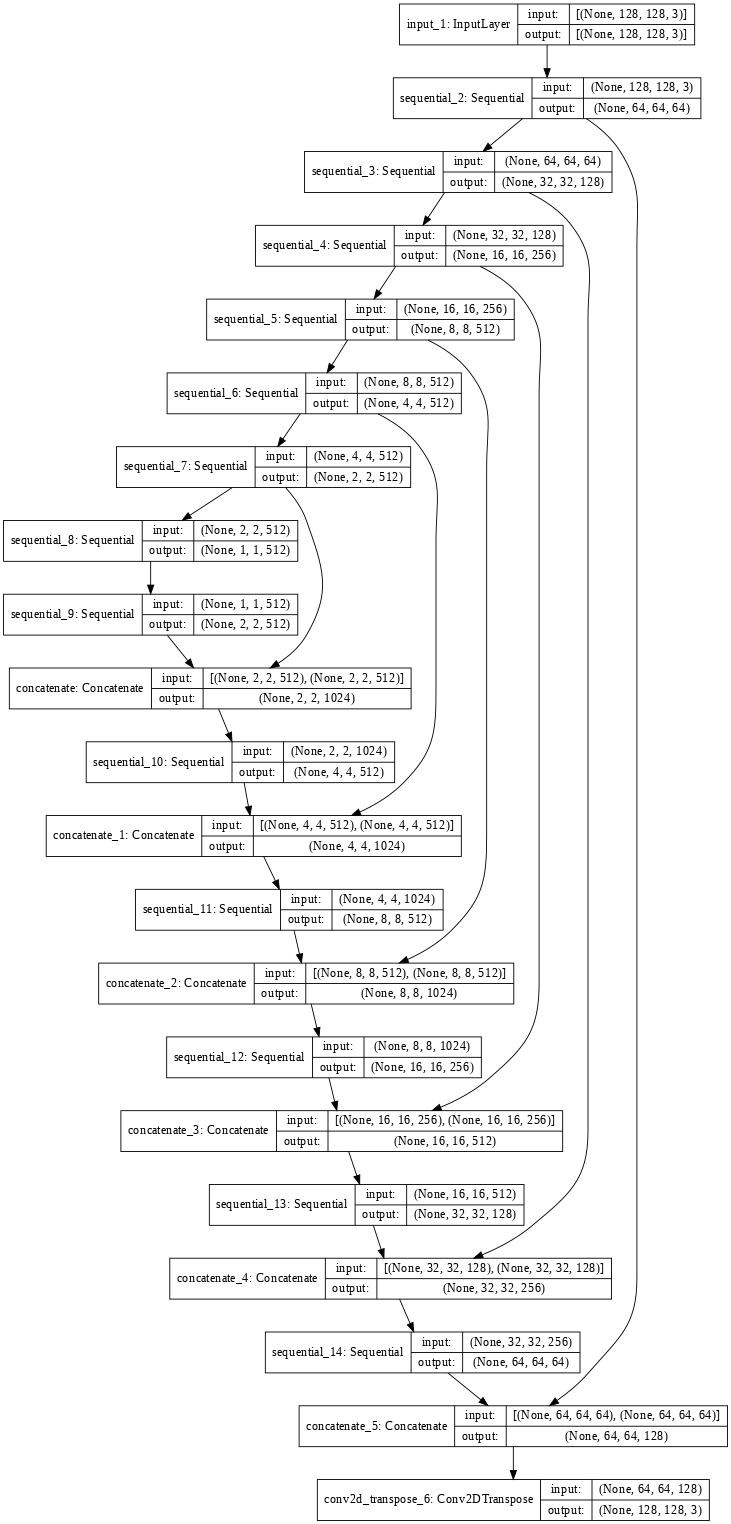

In [35]:
# visualizing the u-net generator architecture
generator = build_generator()
tf.keras.utils.plot_model(generator, show_shapes=True, dpi=64)

## Discriminator

The discriminator is a simple image classifier distinguishing a real anime image from a fake one. Batch Normalization and LeakyReLU layers help to lower the risk of a vanishing gradient problem.

In [36]:
def build_discriminator(image_shape):
    model = Sequential()

    model.add(Conv2D(32, kernel_size=3, strides=2, input_shape=image_shape, 
                     padding="same"))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Dropout(0.25))
    model.add(Conv2D(64, kernel_size=3, strides=2, padding="same"))
    model.add(ZeroPadding2D(padding=((0,1),(0,1))))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Dropout(0.25))
    model.add(Conv2D(128, kernel_size=3, strides=2, padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Dropout(0.25))
    model.add(Conv2D(256, kernel_size=3, strides=1, padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Dropout(0.25))
    model.add(Conv2D(512, kernel_size=3, strides=1, padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))

    return model

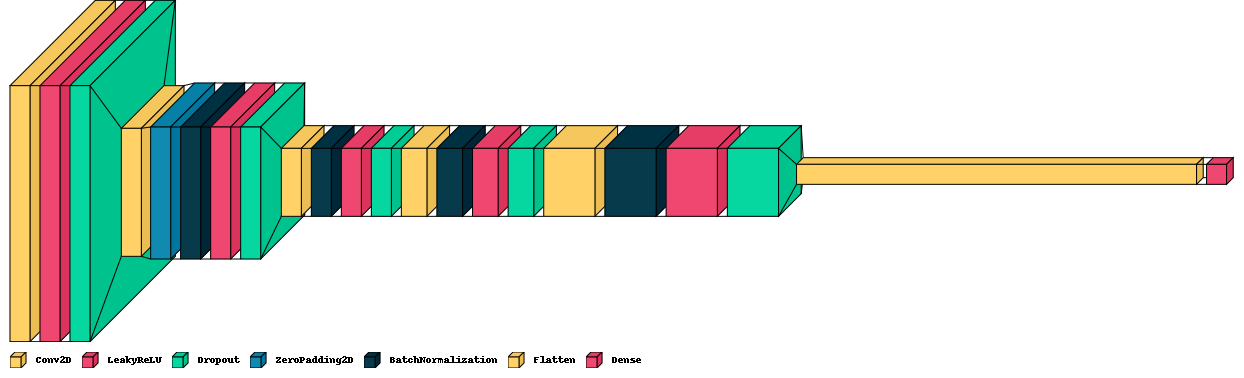

In [37]:
# visualizing the discriminator architecture
discriminator = build_discriminator(real_image_shape)
visualkeras.layered_view(discriminator, legend=True)

In [38]:
# function to generate and save images
def save_images(cnt,real_image):
  image_array = np.full(( 
      preview_margin + (preview_rows * (generate_square+preview_margin)), 
      preview_margin + (preview_cols * (generate_square+preview_margin)), 3), 
      255, dtype=np.uint8)
  
  generated_images = generator.predict(real_image)

  generated_images = 0.5 * generated_images + 0.5

  image_count = 0
  for row in range(preview_rows):
      for col in range(preview_cols):
        r = row * (generate_square+16) + preview_margin
        c = col * (generate_square+16) + preview_margin
        image_array[r:r+generate_square,c:c+generate_square] = generated_images[image_count] * 255
        image_count += 1

          
  output_path = os.path.join(data_path,'output')
  if not os.path.exists(output_path):
    os.makedirs(output_path)
  
  filename = os.path.join(output_path,f"train-{cnt}.png")
  im = Image.fromarray(image_array)
  im.save(filename)

## Loss Function

We will now define the loss function for the discriminator and the generator.

For the discriminator, it is measured by how well it classifies the real anime images as anime (`real_loss`) and the fake anime images from the generator as not anime (`fake_loss`). Therefore, the loss function of the discriminator is the sum of the `real_loss` and `fake_loss`.

On the other hand, the generator is judged by how well it can generate fake anime images which can fool the discriminator into classifying it as real anime image. The loss function of the generator is therefore the cross entropy loss between the discriminator-assigned probability for the generated fake anime images and the real anime images, which have the value of 1

In [39]:
cross_entropy = tf.keras.losses.BinaryCrossentropy()

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

Both the generator and discriminator will use the Adam algorithm with a learning rate of 0.00015 and beta_1 of 0.5 based on commonly chosen values in practice for GANs

In [40]:
generator_optimizer = Adam(1.5e-4,0.5)
discriminator_optimizer = Adam(1.5e-4,0.5)

The train_step function performs the training of both the generator and discriminator and updates their respective weights based on the updating of gradients

In [41]:
@tf.function # decorator which cause train_step function to be compiled
             # as a callable which executes a TensorFlow graph
             # Graphs are data structures that contain a set of tf.Operation 
             # objects, which represent units of computation; and tf.Tensor 
             # objects, which represent the units of data that flow between 
             # operations.
def train_step(anime_images, input_images):

  # track tensorflow computations and calculate gradient w.r.t. some variables
  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    generated_images = generator(input_images, training=True)

    real_output = discriminator(anime_images, training=True)
    fake_output = discriminator(generated_images, training=True)

    gen_loss = generator_loss(fake_output)
    disc_loss = discriminator_loss(real_output, fake_output)
    
    # calculate gradient
    gradients_of_generator = gen_tape.gradient(
        gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(
        disc_loss, discriminator.trainable_variables)

    # apply calculated gradients to variables
    generator_optimizer.apply_gradients(zip(
        gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(
        gradients_of_discriminator, 
        discriminator.trainable_variables))
  return gen_loss,disc_loss

Construct a Checkpoint object

In [42]:
checkpoint_dir = data_path +'training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

We will now train the model for 200 epochs

In [43]:
def train(anime_dataset, input_dataset, epochs):
  start = time.time()

  for epoch in range(epochs):
    epoch_start = time.time()

    gen_loss_list = []
    disc_loss_list = []
    count = 0
    for anime_batch, input_batch in zip(anime_dataset, input_dataset):
      t = train_step(anime_batch, input_batch)
      gen_loss_list.append(t[0])
      disc_loss_list.append(t[1])
      count+=1
      if count == 189: # 6079 anime images/batch size 32 = 189.96
        save_images(epoch,input_batch)  # save an image at the end of each epoch

    g_loss = sum(gen_loss_list) / len(gen_loss_list)
    d_loss = sum(disc_loss_list) / len(disc_loss_list)

    epoch_elapsed = time.time()-epoch_start
    print (f'Epoch {epoch+1}, gen loss={g_loss},disc loss={d_loss}, {hms_string(epoch_elapsed)}')

    # Save the model every 15 epochs
    if (epoch + 1) % 15 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

  elapsed = time.time()-start
  print (f'Training time: {hms_string(elapsed)}')

In [31]:
def train(anime_dataset, input_dataset, epochs):
  start = time.time()

  for epoch in range(epochs):
    epoch_start = time.time()

    gen_loss_list = []
    disc_loss_list = []
    count = 0
    for anime_batch, input_batch in zip(anime_dataset, input_dataset):
      t = train_step(anime_batch, input_batch)
      gen_loss_list.append(t[0])
      disc_loss_list.append(t[1])
      count+=1
      if count == 189: # 6079 anime images/batch size 32 = 189.96
        save_images(epoch,input_batch)  # save an image at the end of each epoch

    g_loss = sum(gen_loss_list) / len(gen_loss_list)
    d_loss = sum(disc_loss_list) / len(disc_loss_list)

    epoch_elapsed = time.time()-epoch_start
    print (f'Epoch {epoch+1}, gen loss={g_loss},disc loss={d_loss}, {hms_string(epoch_elapsed)}')

    # Save the model every 15 epochs
    if (epoch + 1) % 15 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

  elapsed = time.time()-start
  print (f'Training time: {hms_string(elapsed)}')

In [ ]:
train(train_dataset, input_dataset, epochs)

Epoch 1, gen loss=0.9651177525520325,disc loss=2.3127400875091553, 0:26:19.71
Epoch 2, gen loss=1.1624810695648193,disc loss=1.9906120300292969, 0:00:41.34
Epoch 3, gen loss=1.1254007816314697,disc loss=2.0383238792419434, 0:00:41.35
Epoch 4, gen loss=0.9702543020248413,disc loss=1.8454062938690186, 0:00:24.45
Epoch 5, gen loss=0.9721899628639221,disc loss=1.7612841129302979, 0:00:41.33
Epoch 6, gen loss=1.0047118663787842,disc loss=1.699922800064087, 0:00:24.63
Epoch 7, gen loss=1.0301169157028198,disc loss=1.7180278301239014, 0:00:41.33
Epoch 8, gen loss=0.9935131072998047,disc loss=1.682019829750061, 0:00:41.33
Epoch 9, gen loss=1.0384867191314697,disc loss=1.8023604154586792, 0:00:24.65
Epoch 10, gen loss=0.9903724789619446,disc loss=1.6658246517181396, 0:00:41.33
Epoch 11, gen loss=0.9951643943786621,disc loss=1.8057690858840942, 0:00:41.33
Epoch 12, gen loss=1.163650393486023,disc loss=1.9216570854187012, 0:00:41.33
Epoch 13, gen loss=1.0026789903640747,disc loss=1.87406122684478

## Key Observations

Generator outputs from the train set in the 2nd epoch:

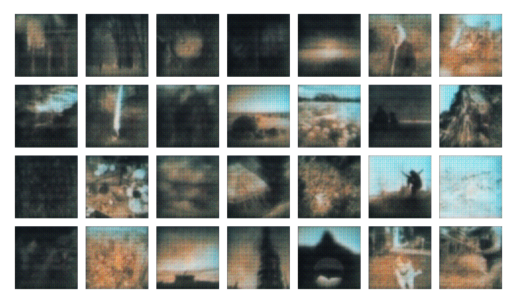

In [1]:
#https://stackoverflow.com/questions/20597088/display-a-png-image-from-python-on-mint-15-linux
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

plt.figure(figsize= (9,6))
img = mpimg.imread("../model_and_gen_img/Basic_GAN_Real_Input/output/train-1.png")
plt.imshow(img)
plt.axis('off')
plt.show()

Generator outputs from the training set in the 200th epoch:

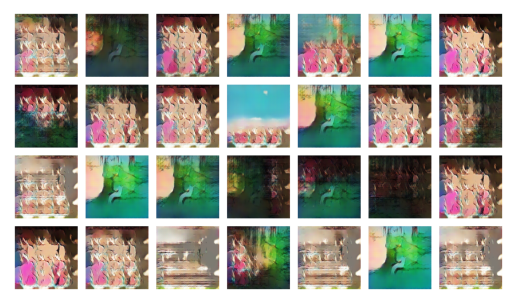

In [3]:
plt.figure(figsize= (9,6))
img = mpimg.imread("../model_and_gen_img/Basic_GAN_Real_Input/output/train-199.png")
plt.imshow(img)
plt.axis('off')
plt.show()

We saw that using real-life images as inputs to a Basic GAN did not result in the transfer of the anime style onto the real-life images. Instead, the Basic GAN model has treated the input images as if they were noise. The content of the input images were still visible in the first few epochs. However, the GAN soon learns to mimic the real anime images as the training progresses. This resulted in the generator merely producing random images with the anime style but with no discernible content from the input, which is similar to results when we input noise vectors.
A probable explanation for this lies in the fact that the loss functions in both the discriminator and the generator do not contain a component which motivate the generator to retain the content of the input image. 

To fulfil the objective of this project, we will need to look at another GAN model which contains such a mechanism for content retention. Please refer to the next notebook "CycleGAN with Ghibli Anime and Real US Attraction"